# Import required libraries

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

#Random Seed
random.seed(47)

# -------------------- Port Traffic Control -------------------
#### Create the DataFrame for port traffic control

In [2]:
df_traffic_control = pd.DataFrame({
    'Vessel_ID': [f'V{i:04d}' for i in range(1, 1001)],
    'Timestamp_Entry': [datetime.now() - timedelta(hours=random.randint(1, 800)) for _ in range(1000)],
    'Timestamp_Exit': [datetime.now() + timedelta(hours=random.randint(1, 800)) for _ in range(1000)],
    'Containers_Unloaded (TEUs)': [random.randint(20, 4578) for _ in range(1000)],
    'Containers_Loaded (TEUs)': [random.randint(20, 4543) for _ in range(1000)]
})

df_traffic_control

,Vessel_ID,Timestamp_Entry,Timestamp_Exit,Containers_Unloaded (TEUs),Containers_Loaded (TEUs)
0,V0001,2023-09-16 15:35:09.238160,2023-11-02 03:35:09.241163,3021,3745
1,V0002,2023-09-28 23:35:09.238160,2023-10-30 04:35:09.241163,3156,2759
2,V0003,2023-09-13 07:35:09.238160,2023-10-17 21:35:09.241163,1597,1979
3,V0004,2023-09-08 01:35:09.238160,2023-10-13 00:35:09.241163,4096,1416
4,V0005,2023-09-12 07:35:09.238160,2023-11-03 09:35:09.241163,597,2847
...,...,...,...,...,...
995,V0996,2023-09-22 07:35:09.241163,2023-10-09 14:35:09.243157,953,1884
996,V0997,2023-09-29 03:35:09.241163,2023-10-08 21:35:09.243157,3668,1422
997,V0998,2023-09-18 01:35:09.241163,2023-10-21 00:35:09.243157,3940,3861
998,V0999,2023-09-18 12:35:09.241163,2023-10-04 15:35:09.243157,2645,2884


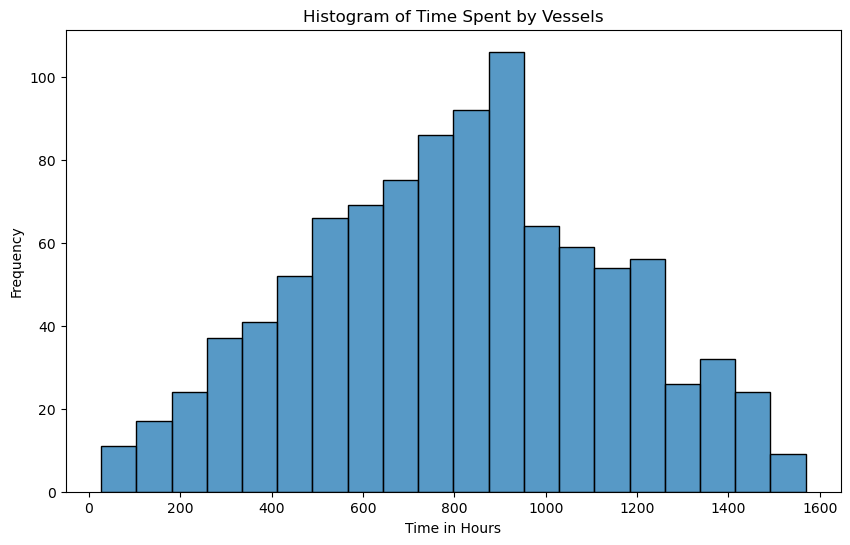

In [3]:
# Add 'Time' column by calculating the difference between 'Timestamp_Exit' and 'Timestamp_Entry'
df_traffic_control['Time'] = df_traffic_control['Timestamp_Exit'] - df_traffic_control['Timestamp_Entry']

# Convert 'Time' column to hours and store in a new column 'Time_in_Hours'
df_traffic_control['Time_in_Hours'] = df_traffic_control['Time'].dt.total_seconds() / 3600

plt.figure(figsize=(10, 6))
sns.histplot(df_traffic_control['Time_in_Hours'], bins=20)
plt.title('Histogram of Time Spent by Vessels')
plt.xlabel('Time in Hours')
plt.ylabel('Frequency')
plt.show()


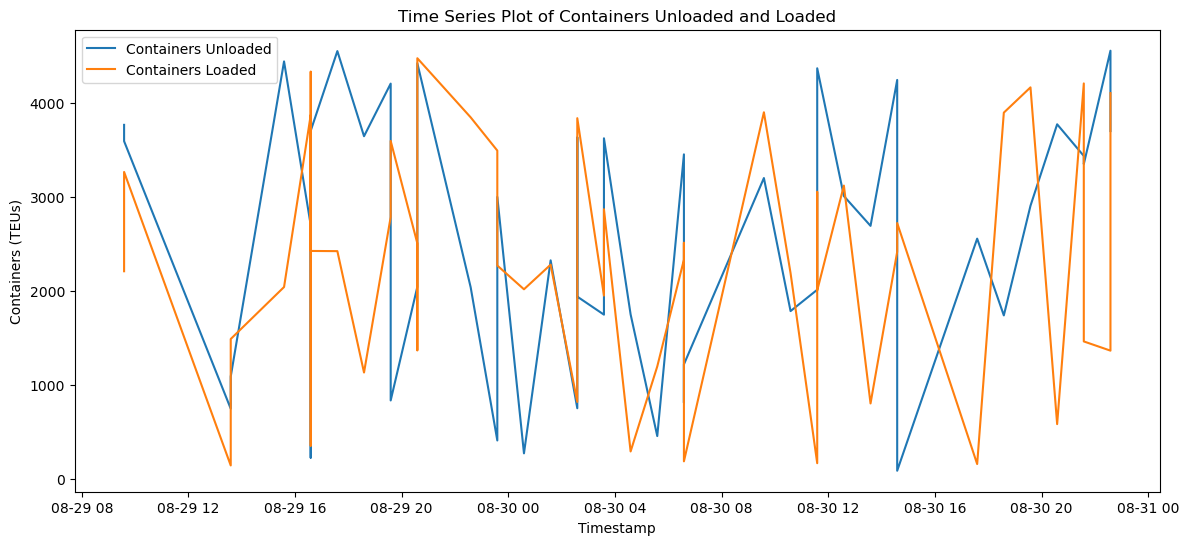

In [4]:
# Sort DataFrame by 'Timestamp_Entry'
df_sorted = df_traffic_control.sort_values('Timestamp_Entry').head(50)  # Taking only first 50 records for better visibility

plt.figure(figsize=(14, 6))
plt.plot(df_sorted['Timestamp_Entry'], df_sorted['Containers_Unloaded (TEUs)'], label='Containers Unloaded', color='tab:blue')
plt.plot(df_sorted['Timestamp_Entry'], df_sorted['Containers_Loaded (TEUs)'], label='Containers Loaded', color='tab:orange')
plt.title('Time Series Plot of Containers Unloaded and Loaded')
plt.xlabel('Timestamp')
plt.ylabel('Containers (TEUs)')
plt.legend()
plt.show()


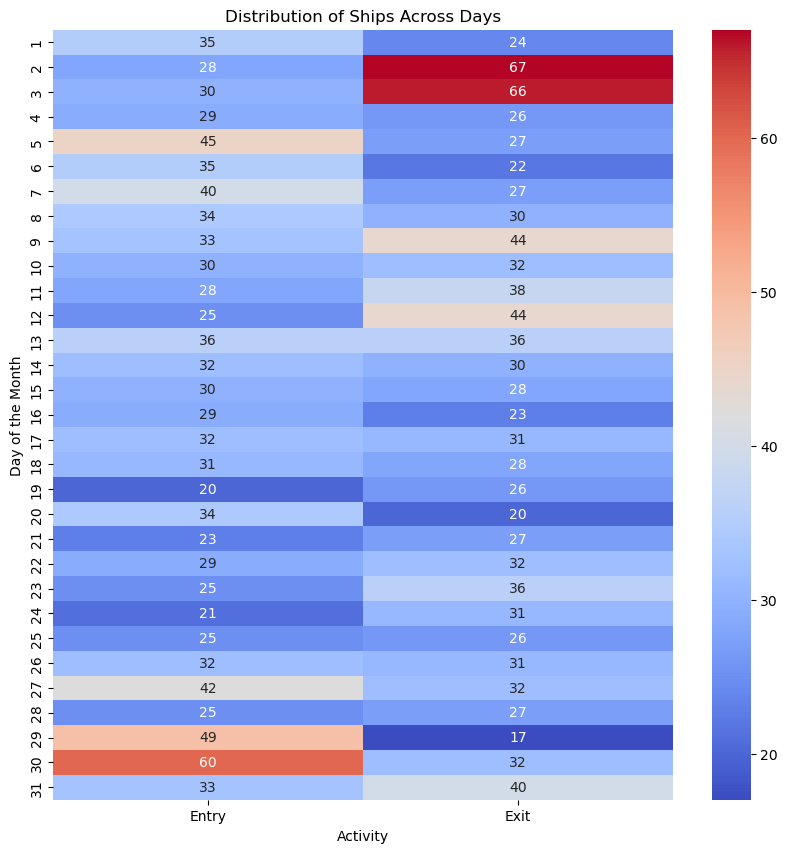

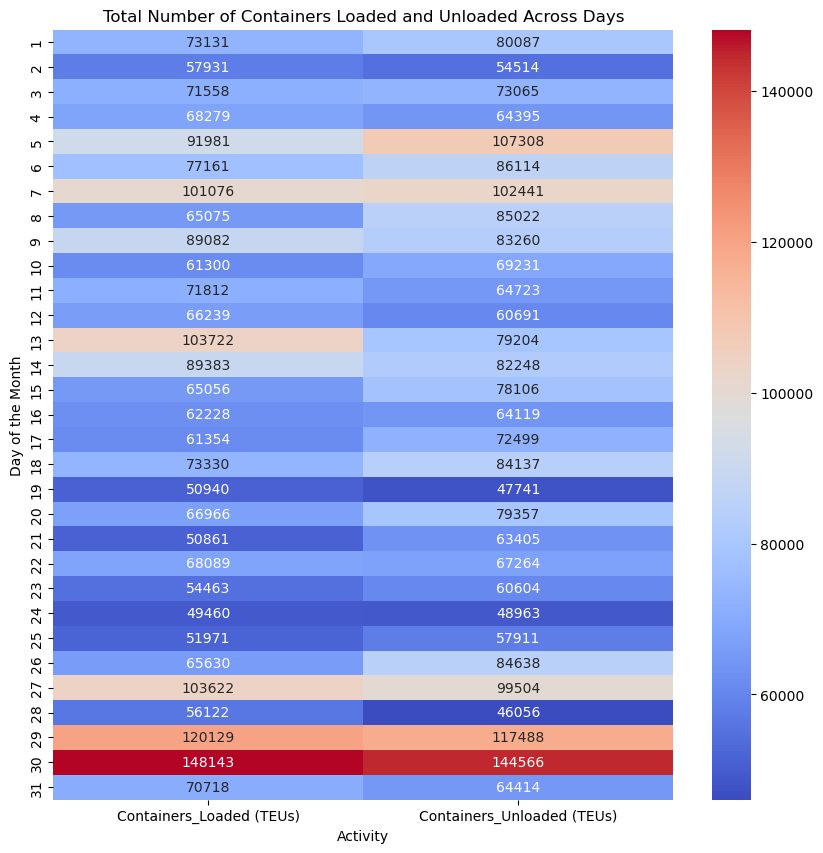

In [5]:
# Extract the day from the timestamps
df_traffic_control['Entry_Day'] = df_traffic_control['Timestamp_Entry'].dt.day
df_traffic_control['Exit_Day'] = df_traffic_control['Timestamp_Exit'].dt.day

# Count the frequency of ships for each day
entry_day_count = df_traffic_control['Entry_Day'].value_counts().sort_index()
exit_day_count = df_traffic_control['Exit_Day'].value_counts().sort_index()

# Create a DataFrame for the heatmap
df_heatmap_days = pd.DataFrame({
    'Entry': entry_day_count,
    'Exit': exit_day_count
}).fillna(0)

# Distribution of Ships Across Days
plt.figure(figsize=(10, 10))
sns.heatmap(df_heatmap_days, annot=True, cmap='coolwarm', fmt='g')
plt.title('Distribution of Ships Across Days')
plt.xlabel('Activity')
plt.ylabel('Day of the Month')
plt.show()

# Sum the total number of containers for each day
container_day_sum = df_traffic_control.groupby('Entry_Day')[['Containers_Loaded (TEUs)', 'Containers_Unloaded (TEUs)']].sum().sort_index()

# Create a DataFrame for the heatmap
df_heatmap_containers = pd.DataFrame(container_day_sum).fillna(0)

# Total Number of Containers Loaded and Unloaded Across Days
plt.figure(figsize=(10, 10))
sns.heatmap(df_heatmap_containers, annot=True, cmap='coolwarm', fmt='g')
plt.title('Total Number of Containers Loaded and Unloaded Across Days')
plt.xlabel('Activity')
plt.ylabel('Day of the Month')
plt.show()


# ------------------ Demand Forecasting -------------------

In [6]:
# Create a date range for the dataset
start_date = datetime(2020, 1, 1)
end_date = datetime(2021, 12, 31)
date_range = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

# Create an empty DataFrame to store the mock-up dataset
data = {
    "Month": [],
    "Seasonality": [],
    "MarketTrends": [],
    "Temperature": [],
    "CompetitorPrices": [],
    "Demand": []
}

# Generate data for each date in the date range
num_samples = 25000
for _ in range(num_samples):
    date = np.random.choice(date_range)
    seasonality = np.sin(2 * np.pi * date.month / 12)
    market_trends = seasonality + np.random.uniform(-0.1, 0.1)
    temperature = np.random.uniform(10, 30)
    competitor_prices = 100 + seasonality * 50 + np.random.normal(0, 10)
    demand = 200 - (2 * seasonality) + (3 * market_trends) + (4 * temperature) + (1.5 * competitor_prices) + np.random.normal(0, 20)
    month = date.month
    data["Month"].append(month)
    data["Seasonality"].append(seasonality)
    data["MarketTrends"].append(market_trends)
    data["Temperature"].append(temperature)
    data["CompetitorPrices"].append(competitor_prices)
    data["Demand"].append(demand)

# Create the DataFrame
mockup_dataset = pd.DataFrame(data)

mockup_dataset

,Month,Seasonality,MarketTrends,Temperature,CompetitorPrices,Demand
0,12,-2.449294e-16,-0.017160,20.568854,88.537847,423.251442
1,3,1.000000e+00,1.003621,28.797313,156.166917,536.264067
2,6,1.224647e-16,0.040557,29.234348,113.384365,463.819135
3,12,-2.449294e-16,0.027951,27.174738,108.361386,493.499174
4,4,8.660254e-01,0.917115,23.629850,149.784248,528.222185
...,...,...,...,...,...,...
24995,1,5.000000e-01,0.470211,11.153089,128.089517,441.132065
24996,11,-5.000000e-01,-0.528909,16.317081,53.465652,406.939864
24997,4,8.660254e-01,0.854570,17.381015,141.889711,491.338242
24998,7,-5.000000e-01,-0.414785,21.986286,74.278553,401.583612


Text(0, 0.5, 'Seasonality')

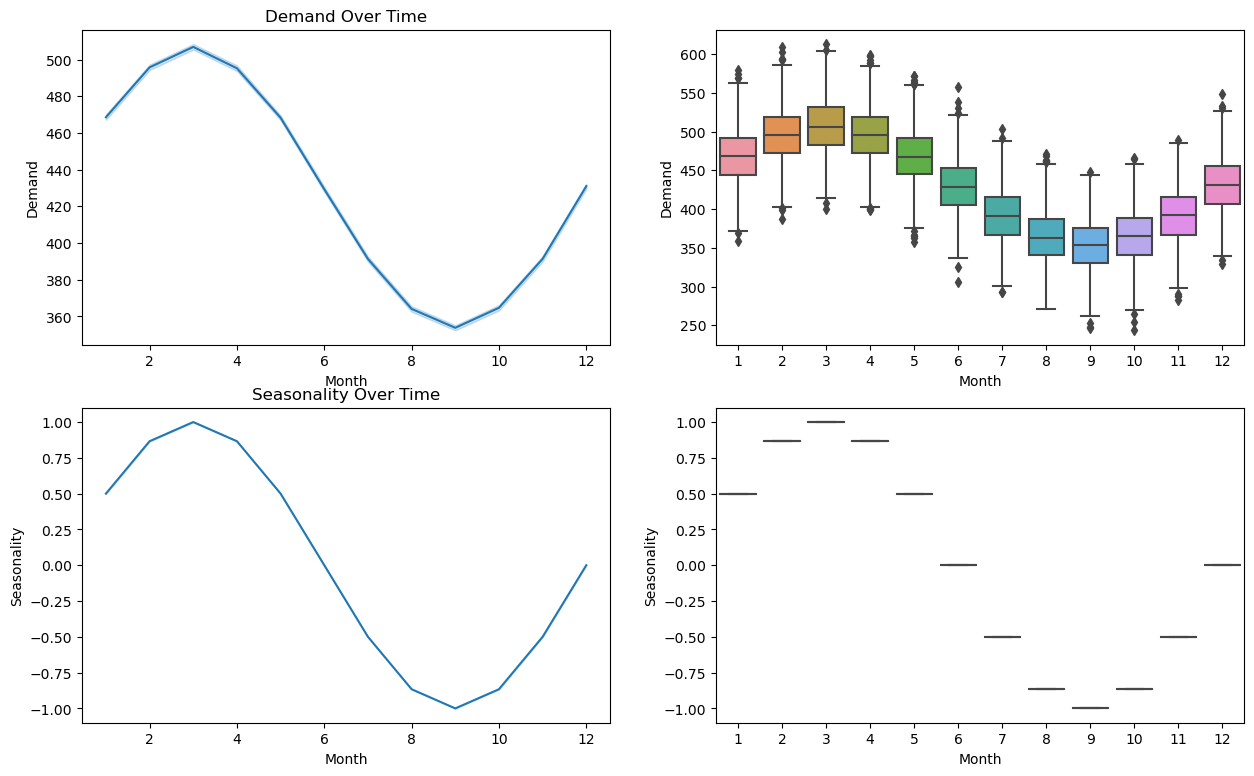

In [7]:
fig, axes = plt.subplots(2,2,figsize=(15,9))

sns.lineplot(x='Month', y='Demand', data=mockup_dataset, ax=axes[0, 0])
axes[0, 0].set_title('Demand Over Time')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Demand')

sns.boxplot(x='Month', y='Demand', data=mockup_dataset, ax=axes[0, 1])
axes[0, 0].set_title('Demand Over Time')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Demand')

sns.lineplot(x='Month', y='Seasonality', data=mockup_dataset, ax=axes[1, 0])
axes[1, 0].set_title('Seasonality Over Time')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Seasonality')

sns.boxplot(x='Month', y='Seasonality', data=mockup_dataset, ax=axes[1, 1])
axes[1, 0].set_title('Seasonality Over Time')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Seasonality')


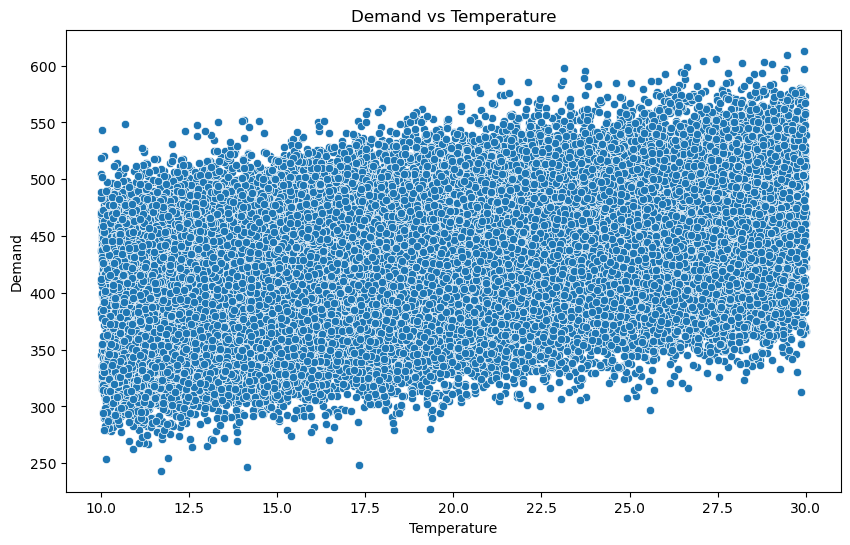

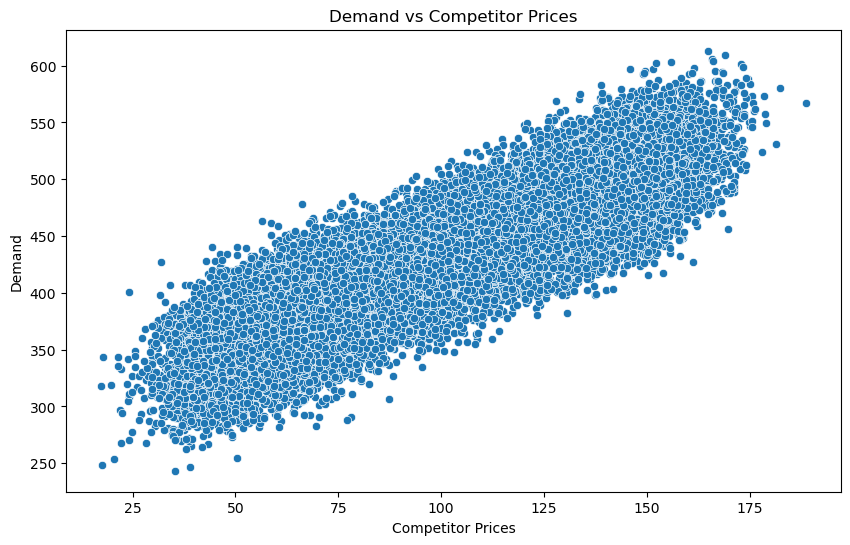

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Demand', data=mockup_dataset)
plt.title('Demand vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Demand')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='CompetitorPrices', y='Demand', data=mockup_dataset)
plt.title('Demand vs Competitor Prices')
plt.xlabel('Competitor Prices')
plt.ylabel('Demand')
plt.show()

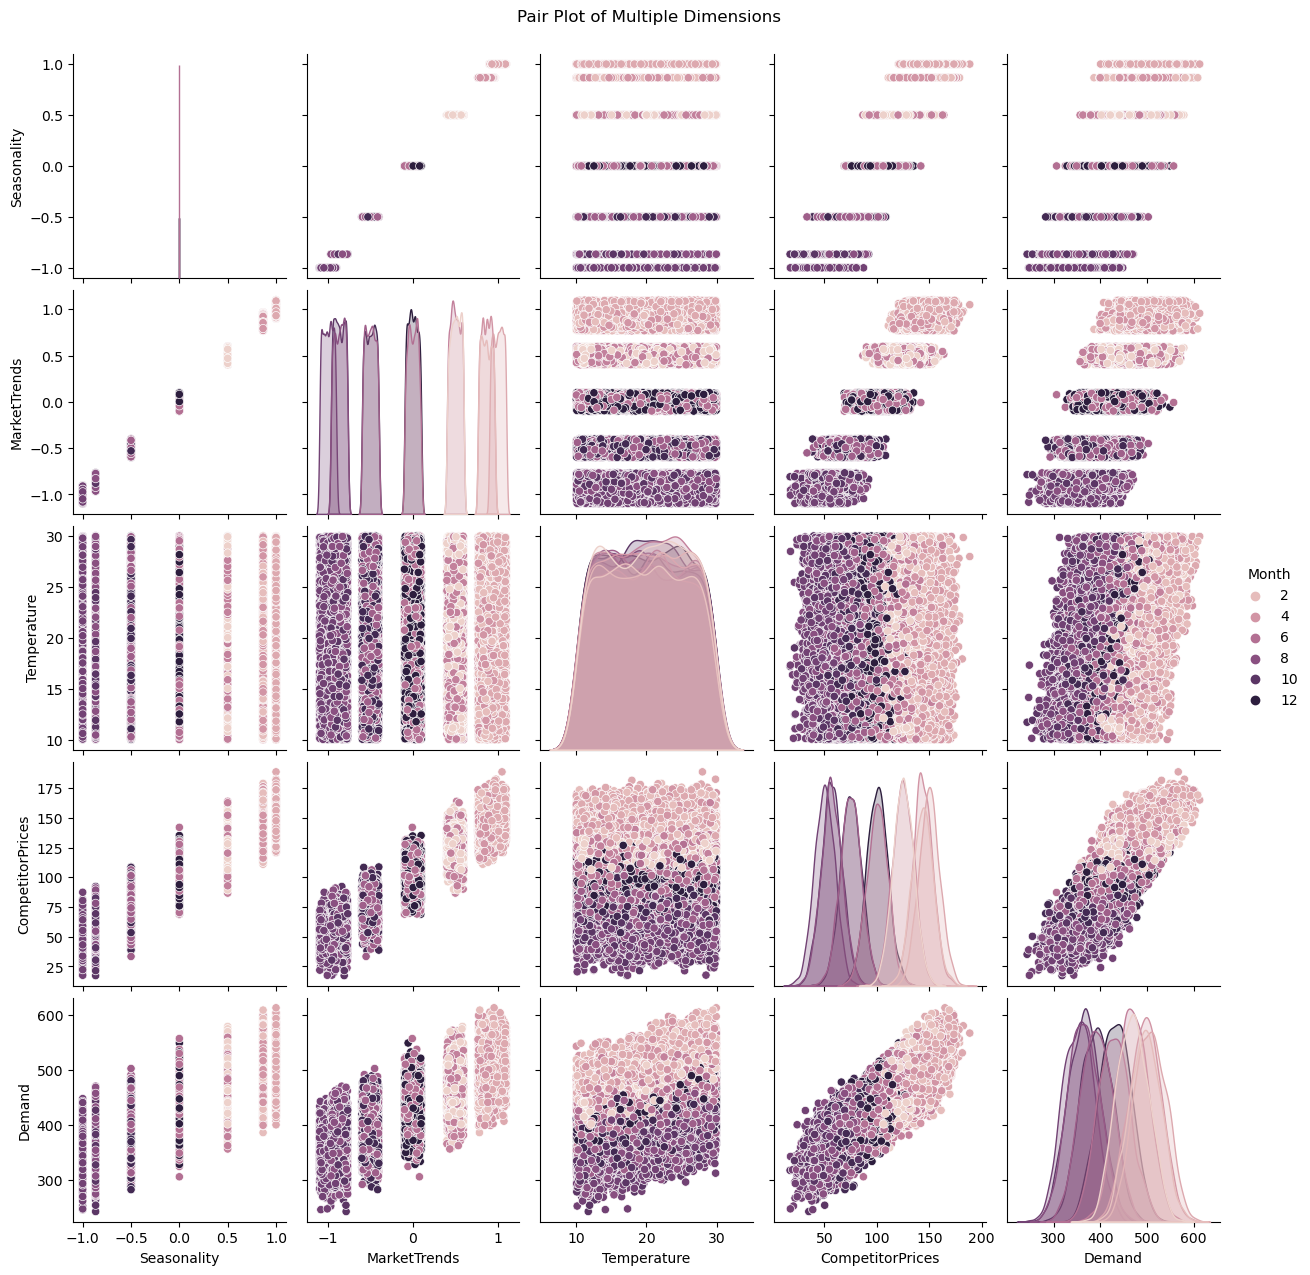

In [9]:
# Create a pair plot
sns.pairplot(mockup_dataset, hue='Month', diag_kind='kde', kind='scatter')
plt.suptitle('Pair Plot of Multiple Dimensions', y=1.02)
plt.show()


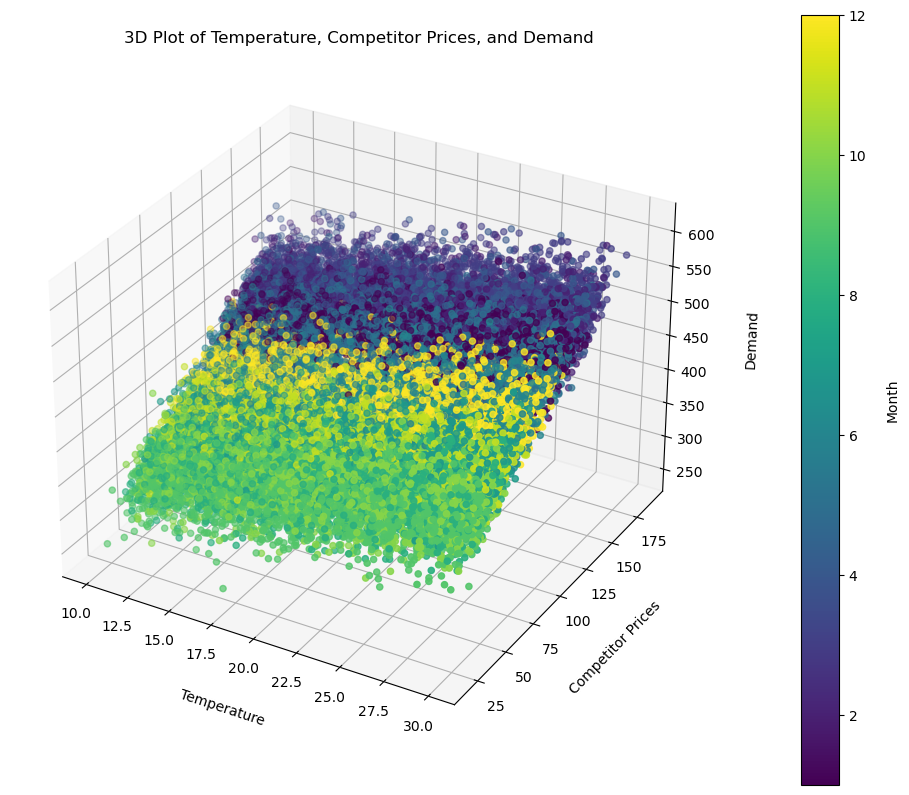

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(mockup_dataset['Temperature'], mockup_dataset['CompetitorPrices'], mockup_dataset['Demand'], c=mockup_dataset['Month'], cmap='viridis')

# Set labels and title
ax.set_xlabel('Temperature', labelpad=14)
ax.set_ylabel('Competitor Prices', labelpad=14)
ax.set_zlabel('Demand', labelpad=16)
plt.title('3D Plot of Temperature, Competitor Prices, and Demand')

# Add colorbar as legend
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Month', labelpad=14)

plt.show()


# -------------- Data Preprocessing for Neural Network --------------


In [11]:
# Data Preprocessing
target = "Demand"
features = ["Month", "Seasonality", "MarketTrends", "Temperature", "CompetitorPrices"]
X = mockup_dataset[features].values
y = mockup_dataset[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


# -------------- Neural Network Model Definition ------------------------

In [12]:
# Neural Network Model
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the neural network model
input_size = len(features)
hidden_size = 64
output_size = 1
model = FeedForwardNN(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader for batch training
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



# ---------------------- Training and Evaluation ----------------------

In [13]:
# ---------------------- Training Loop ----------------------
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()

# ---------------------- Evaluation ----------------------
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

# Convert predictions and ground truth to numpy arrays
y_test_np = y_test_tensor.numpy()

# Evaluate the model
mae = mean_absolute_error(y_test_np, y_pred)
r2 = r2_score(y_test_np, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²) Score: {r2:.4f}")

Mean Absolute Error (MAE): 15.90
R-squared (R²) Score: 0.8997


# ---------------------- Integration ----------------------

In [14]:
# Generate demand forecasts for each month using the trained neural network model
forecasted_demand = []
for month in range(1, 13):
    input_data = torch.tensor([[month] + [random.uniform(-1, 1), random.uniform(-0.1, 0.1), random.uniform(10, 30), random.uniform(50, 150)]], dtype=torch.float32)
    forecast = model(input_data).item()
    forecasted_demand.append(forecast)

# Create a DataFrame for the demand forecasts
months = list(range(1, 13))
demand_df = pd.DataFrame({"Month": months, "Forecasted Demand (TEU)": forecasted_demand})
print(demand_df)
print()

# Use the demand forecast to optimize the number of containers to be loaded/unloaded
# Define the objective function coefficients (for maximizing)
c = [-1, -1]  # Maximize x + y

# Define the inequality constraints (A*x <= b)
A = [[1, 0], [0, 1], [1, 1]]
b = [df_traffic_control['Containers_Unloaded (TEUs)'].max(), df_traffic_control['Containers_Loaded (TEUs)'].max(), sum(forecasted_demand)]

# Solve the linear programming problem
res = linprog(c, A_ub=A, b_ub=b, method='highs')

# Extract and print the results
optimal_unload = res.x[0]
optimal_load = res.x[1]
print(f"Optimal number of containers to unload (TEUs) per month : {optimal_unload}")
print(f"Optimal number of containers to load (TEUs) per month: {optimal_load}")



    Month  Forecasted Demand (TEU)
0       1              7598.922852
1       2              4095.255127
2       3              6197.717285
3       4              5907.407715
4       5              7173.189453
5       6              7312.934082
6       7              5718.857422
7       8              6671.198730
8       9              5748.704102
9      10              4606.439453
10     11              7038.401367
11     12              7990.245117

Optimal number of containers to unload (TEUs) per month : 4578.0
Optimal number of containers to load (TEUs) per month: 4543.0


# ---------------------- Visualization ----------------------

In [68]:
# Number of containers
num_containers = int(optimal_load)

# Create a list of container IDs (e.g., C001, C002, ...)
container_ids = ["C{:03d}".format(i) for i in range(1, num_containers + 1)]

# Define the possible capacity values
capacity_values = [20, 30, 40, 50, 60, 70, 80, 90, 100]

# Generate random capacities for the containers (choosing from the defined values)
capacities = [random.choice(capacity_values) for _ in range(num_containers)]

# Generate random shipping status for the containers (0 for not shipping, 1 for shipping)
shipping_status = [random.choice([0, 1]) for _ in range(num_containers)]

# Create a DataFrame for the supply dataset
supply_data = {
    "ContainerID": container_ids,
    "Capacity (Mt)": capacities,
    "Shipping Status": shipping_status
}

supply_df = pd.DataFrame(supply_data)
supply_df

,ContainerID,Capacity (Mt),Shipping Status
0,C001,80,0
1,C002,70,1
2,C003,40,1
3,C004,60,1
4,C005,70,1
...,...,...,...
4538,C4539,100,1
4539,C4540,50,0
4540,C4541,60,0
4541,C4542,20,0


# First fit

# Best-fit

In [76]:
# Create a dictionary to map month names to their numbers
month_numbers = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec"
}

# Create a dictionary to track the time since allocation for each container
container_allocation_time = {}

# Define a function to perform allocation and forecasting for a specific month
def allocate_and_forecast(month, seasonality, market_trends, temperature, competitor_prices):
    # Get the month number from its name
    month_num = int(month)
    month = month_numbers[month_input]
    
    # Check if the month number is valid
    if month_num < 1 or month_num > 12:
        print("Invalid month input. Please enter a number between 1 and 12.")
        return
    
    # Convert input features to a PyTorch tensor
    input_data = torch.tensor([[month_num, seasonality, market_trends, temperature, competitor_prices]], dtype=torch.float32)
    
    # Use the trained model to forecast demand for the specified month
    forecasted_demand = model(input_data).item() * 10
    print(f"Forecasted Demand for {month}: {forecasted_demand:.2f} Mt")
    
    # Create a copy of the supply dataset for this month
    allocation_df = supply_df.copy()
    allocation_df["Allocated (Mt)"] = 0  # Initialize the allocated column

    # Filter containers to include only those with Shipping Status equal to 1
    eligible_containers = allocation_df[allocation_df["Shipping Status"] == 1]
    
    # Shuffle the eligible containers randomly for each month
    #eligible_containers = eligible_containers.sample(frac=1)
    
    # Calculate daily allocation
    daily_allocation = forecasted_demand / 31  # Divide monthly demand by the number of days in the month
    
    # Initialize a variable to keep track of the total allocated resources for the month
    total_allocated_resources = 0
    
    allocated_container_ids_month = []
    
    for day in range(1, 32):
        
        # Reset daily demand to the calculated daily allocation
        daily_demand = daily_allocation
        
        # Filter out already allocated containers from eligible containers
        eligible_containers = eligible_containers[~eligible_containers["ContainerID"].isin(allocated_container_ids_month)]
        
        # Remove containers from the allocation time tracking if they were allocated 20 days ago
        containers_to_remove = [container_id for container_id, allocation_time in container_allocation_time.items() if allocation_time <= 20]
        for container_id in containers_to_remove:
            del container_allocation_time[container_id]
        
        # Add the containers with allocation time less than 20 days back to eligible_containers
        eligible_containers = pd.concat([eligible_containers, supply_df[supply_df["ContainerID"].isin(containers_to_remove)]])
        
        # Create a list to store allocated container IDs for this day
        allocated_container_ids = []
        
        for _, container_row in eligible_containers.iterrows():
            container_id = container_row["ContainerID"]
            
            # Check if the container was allocated within the last 20 days
            if container_id in container_allocation_time and container_allocation_time[container_id] < 20:
                continue
            
            capacity = container_row["Capacity (Mt)"]

            if daily_demand >= capacity:
                allocation_df.at[_, "Allocated (Mt)"] = capacity
                daily_demand -= capacity
                total_allocated_resources += capacity
                allocated_container_ids.append(container_id)  # Add allocated container ID to the list
                allocated_container_ids_month.append(container_id)
                
                # Update the allocation time for the container
                container_allocation_time[container_id] = 0
                
                # Set the shipping status of the container to 0
                allocation_df.at[_, "Shipping Status"] = 0
            else:
                # Find the containers with capacity just above daily_demand
                available_containers = eligible_containers[eligible_containers["Capacity (Mt)"] > daily_demand]
                # Sort the available containers by capacity and select the one with the smallest capacity above daily_demand
                selected_container = available_containers.nsmallest(1, "Capacity (Mt)", keep="all").iloc[0]
                selected_container_id = selected_container["ContainerID"]
                allocation_df.at[_, "Allocated (Mt)"] = daily_demand
                total_allocated_resources += daily_demand  # Update total allocation
                daily_demand = 0
                allocated_container_ids.append(selected_container_id)  # Add allocated container ID to the list
                allocated_container_ids_month.append(selected_container_id)

                # Update the allocation time for the container
                container_allocation_time[selected_container_id] = 0

                # Set the shipping status of the container to 0
                allocation_df.at[_, "Shipping Status"] = 0

            if daily_demand == 0:
                break
        
        # Increment the allocation time for all containers
        for container_id in container_allocation_time:
            container_allocation_time[container_id] += 1
        
        # Print detailed information of allocated containers for this day
        print(f"Detailed Information of Allocated Containers for {month}, Day {day}:")
        allocated_containers_info = allocation_df[allocation_df["ContainerID"].isin(allocated_container_ids)]
        
        # Filter out containers with Shipping Status equal to 1
        allocated_containers_info = allocated_containers_info[allocated_containers_info["Shipping Status"] != 1]
        print(allocated_containers_info)
        print("\n")
        
    
# Interactive input
month_input = int(input("Enter the month (e.g., '1-12'): "))
seasonality = float(input("Enter the seasonality factor: "))
market_trends = float(input("Enter the market trends factor: "))
temperature = float(input("Enter the temperature: "))
competitor_prices = float(input("Enter the competitor prices: "))

# Call the allocate_and_forecast function with user input
allocate_and_forecast(month_input, seasonality, market_trends, temperature, competitor_prices)

Enter the month (e.g., '1-12'): 3
Enter the seasonality factor: 0.01
Enter the market trends factor: 0.01
Enter the temperature: 20
Enter the competitor prices: 100
Forecasted Demand for Mar: 67381.53 Mt
Detailed Information of Allocated Containers for Mar, Day 1:
   ContainerID  Capacity (Mt)  Shipping Status  Allocated (Mt)
1         C002             70                0            70.0
2         C003             40                0            40.0
3         C004             60                0            60.0
4         C005             70                0            70.0
6         C007             70                0            70.0
7         C008             40                0            40.0
10        C011             40                0            40.0
11        C012             70                0            70.0
14        C015             60                0            60.0
19        C020            100                0           100.0
21        C022             30             

# ---------------------- Final Metrics and Outputs ----------------------

In [ ]:
# Print or save the final metrics and outputs
print(f"Mean Absolute Error (MAE) for Demand Forecasting: {mae:.2f}")
print(f"R-squared (R²) Score for Demand Forecasting: {r2:.4f}")
print(f"Optimal number of containers to unload (TEUs): {optimal_unload}")
print(f"Optimal number of containers to load (TEUs): {optimal_load}")

# ---------------------- Dynamic Allocation ----------------------


In [34]:
# Function to allocate containers based on real-time demand
def allocate_containers(demand, supply_df):
    allocation_df = supply_df.copy()
    allocation_df["Allocated (Mt)"] = 0
    eligible_containers = allocation_df[allocation_df["Shipping Status"] == 1]
    eligible_containers = eligible_containers.sample(frac=1)
    for _, container_row in eligible_containers.iterrows():
        capacity = container_row["Capacity (Mt)"]
        if demand >= capacity:
            allocation_df.at[_, "Allocated (Mt)"] = capacity
            demand -= capacity
        else:
            allocation_df.at[_, "Allocated (Mt)"] = demand
            demand = 0
        if demand == 0:
            break
    return allocation_df

# ---------------------- Priority Queue ----------------------
# Sort vessels by cargo size and time of arrival
sorted_vessels = df_traffic_control.sort_values(by=['Containers_Loaded (TEUs)', 'Timestamp_Entry'], ascending=[False, True])


In [38]:
# ---------------------- Yard Utilization ----------------------
# Function to optimize yard space
def optimize_yard_space(allocation_df):
    # Assuming each stack can hold 10 containers
    max_stack_height = 10
    stacks = []
    for _, row in allocation_df.iterrows():
        allocated = row["Allocated (Mt)"]
        if allocated > 0:
            placed = False
            for stack in stacks:
                if sum(stack) + allocated <= max_stack_height:
                    stack.append(allocated)
                    placed = True
                    break
            if not placed:
                stacks.append([allocated])
    return stacks

In [39]:
# ---------------------- Enhanced Analysis and Optimization ----------------------
# Generate demand forecasts for each month
forecasted_demands = []
for month in range(1, 13):
    input_data = torch.tensor([[month] + [random.uniform(-1, 1), random.uniform(-0.1, 0.1), random.uniform(10, 30), random.uniform(50, 150)]], dtype=torch.float32)
    forecast = model(input_data).item()
    forecasted_demands.append(forecast)

# Create a DataFrame for supply dataset
num_containers = 500
container_ids = ["C{:03d}".format(i) for i in range(1, num_containers + 1)]
capacities = [random.randint(20, 100) for _ in range(num_containers)]
shipping_status = [random.choice([0, 1]) for _ in range(num_containers)]
supply_data = {
    "ContainerID": container_ids,
    "Capacity (Mt)": capacities,
    "Shipping Status": shipping_status
}
supply_df = pd.DataFrame(supply_data)

In [40]:
# Allocate containers and optimize yard space for each month
for month, demand in zip(range(1, 13), forecasted_demands):
    print(f"Month: {month}, Forecasted Demand: {demand}")
    allocation_df = allocate_containers(demand, supply_df)
    print("Container Allocation:")
    print(allocation_df)
    optimized_stacks = optimize_yard_space(allocation_df)
    print(f"Optimized Yard Space: {optimized_stacks}")

# You can also visualize these optimizations and allocations as needed.


Month: 1, Forecasted Demand: 7040.9306640625
Container Allocation:
    ContainerID  Capacity (Mt)  Shipping Status  Allocated (Mt)
0          C001             81                1             0.0
1          C002             71                0             0.0
2          C003             20                0             0.0
3          C004             34                0             0.0
4          C005             97                1            97.0
..          ...            ...              ...             ...
495        C496             34                0             0.0
496        C497             40                0             0.0
497        C498             84                0             0.0
498        C499             29                0             0.0
499        C500            100                0             0.0

[500 rows x 4 columns]
Optimized Yard Space: [[97.0], [32.0], [29.0], [62.0], [45.0], [97.0], [69.0], [62.0], [82.0], [30.0], [58.0], [20.0], [62.0], [74.0], [32.0]